# wget the UCSC human-chimp (hg19-panTro6) .maf file

In [3]:
%%bash

wget https://hgdownload.cse.ucsc.edu/goldenpath/hg19/vsPanTro6/hg19.panTro6.synNet.maf.gz -q -O "human_chimp_divergence/hg19.panTro6.synNet.maf.gz"


# wget hg19 fasta files

In [4]:
%%bash

mkdir -p "human_chimp_divergence/genome" 

for chr in {1..22} X Y; do
    wget "https://hgdownload.cse.ucsc.edu/goldenpath/hg19/chromosomes/chr${chr}.fa.gz" -q -O "human_chimp_divergence/genome/hg19.chr${chr}.fa.gz"
done


# Filtering the UCSC human-chimp (hg19-panTro6) .maf file for Y chromosome alignments

In [1]:
from human_chimp_divergence.maf_filter_by_species_set import filter_maf

chimp = 'panTro6'
human = 'hg19'

contigs = {
    'human' : 'chrY',
    'chimp' : 'chrY'
}

input_maf = 'human_chimp_divergence/hg19.panTro6.synNet.maf.gz'
filtered_maf_chrY = 'human_chimp_divergence/chrY.hg19.panTro6.maf'

filter_maf(human, chimp, input_maf, contigs, 2000, filtered_maf_chrY)

# Using the human-chimp .maf file to determine the pairwise identity for each base of the hg19 Y chromosome

In [2]:
from human_chimp_divergence.maf_to_pairwise_identity import maf_to_pairwise_identity

human = 'hg19'
chimp = 'panTro6'

input_maf_chrY = 'human_chimp_divergence/chrY.hg19.panTro6.maf'
identity_file = 'human_chimp_divergence/chrY.hg19.panTro6.maf.pairwise_identity'

# chimp_vcf = 'full_chimp.hg19.vcf'

fasta_files = {
	human : "human_chimp_divergence/genome/hg19.chrY.fa.gz",
    chimp : "",
}

maf_to_pairwise_identity(fasta_files, input_maf_chrY, identity_file, None)


# Using a 400bp rolling window to calculate the pairwise identity for each base of the hg19 Y chromosome

In [5]:
import pandas as pd
import numpy as np

def get_identity(dna_sequence, sequence_len=200, missing_cutoff=100):
    missing_mask = dna_sequence == 4
    num_missing = np.sum(missing_mask)

    # Return NaN if missing values exceed the cutoff
    if num_missing >= missing_cutoff:
        return np.nan
    else:
        filtered_sequence = dna_sequence[~missing_mask]

        sequence_identity = np.sum(filtered_sequence == 0) / (sequence_len - num_missing)
        return sequence_identity

sequence_len = 400
min_len = 200
missing_cutoff = sequence_len - min_len

start_pos = 2500000
end_pos = 30000000

pairwise_identity_file = 'human_chimp_divergence/chrY.hg19.panTro6.maf.pairwise_identity'
out_file = 'human_chimp_divergence/hg19_panTro6_chrY_identity_rolling_window.' + str(sequence_len) + '_' + str(min_len) + '.{}_{}'.format(start_pos, end_pos)

pairwise_identity = pd.read_csv(pairwise_identity_file, sep='\t', header=None, index_col=None)

pairwise_identity_full = pd.DataFrame(index=range(0, 59373566))
pairwise_identity_full[0] = 'N'
pairwise_identity_full.loc[pairwise_identity_full.index.isin(pairwise_identity[1].values), 0] = pairwise_identity[2].values

pairwise_identity_full = pairwise_identity_full[start_pos-1:end_pos].copy()

pairwise_identity_full.loc[pairwise_identity_full[0] == 'M', 0] = 0
pairwise_identity_full.loc[pairwise_identity_full[0] == 'S', 0] = 1
pairwise_identity_full.loc[pairwise_identity_full[0] == 'I', 0] = 2
pairwise_identity_full.loc[pairwise_identity_full[0] == 'D', 0] = 3
pairwise_identity_full.loc[pairwise_identity_full[0] == 'N', 0] = 4

human_chimp_identity_rolling_window = pairwise_identity_full.rolling(sequence_len, center=True).apply(get_identity, kwargs={'sequence_len': sequence_len, 'missing_cutoff': missing_cutoff})
human_chimp_identity_rolling_window.to_csv(out_file + '.csv', sep='\t', header=None, na_rep='')


# Finding the human-chimp divergence cutoff where the missing mutation effect is minimised

In [1]:
import pandas as pd
import numpy as np

import utils.VcfHandler as VcfHandler
import utils.YChrDataset as YChrDataset
import pickle

rng = np.random.default_rng()

# Filter samples to exclude ancient samples and categorize them based on haplogroups
samples = [sample for sample in YChrDataset.samples if sample not in YChrDataset.ancient_samples]
non_divergent_haplogroups = [x for x in samples if YChrDataset.GetHaplogroup(x)[0] not in ['A', 'B']]
divergent_haplogroups = [x for x in samples if YChrDataset.GetHaplogroup(x)[0] in ['A', 'B']]

# Load genotype data and merge with identity data
human_chimp_identity_df = pd.read_csv('human_chimp_divergence//hg19_panTro6_chrY_identity_rolling_window.400_200.2500000_30000000.csv', sep='\t', header=None, names=['identity'])
human_chimp_identity_df['POS'] = human_chimp_identity_df.index + 1

vcf_data = pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl')
genotype_data_full = VcfHandler.get_genotypes_from_vcf_dataframe(vcf_data)
genotype_data_full_identity = pd.merge(genotype_data_full, human_chimp_identity_df, on=['POS'], how='inner')
genotype_data_full_identity['identity'] = genotype_data_full_identity['identity'] * 100

# Define identity cutoffs for analysis
start = 97
end = 99
identity_cutoff = np.round(np.arange(start, end + 0.1, 0.1, dtype=float), 2)
identity_cutoff_str = [str(x) for x in identity_cutoff]

res_num_positions = pd.DataFrame(columns=identity_cutoff_str)
res_full = {}

# Loop over divergent haplogroups
for divergent_haplogroup in divergent_haplogroups:
    print(divergent_haplogroup)

    # Initialize dataframes for storing results for this divergent haplogroup
    diff_df = pd.DataFrame(columns=identity_cutoff_str)
    diff_df_normalised = pd.DataFrame(columns=identity_cutoff_str)
    positions_df = pd.DataFrame(columns=identity_cutoff_str)
    ci_df = pd.DataFrame(columns=identity_cutoff_str)
    ci_df_normalised = pd.DataFrame(columns=identity_cutoff_str)

    # Compare this divergent haplogroup with all non-divergent haplogroups
    for non_divergent_haplogroup in non_divergent_haplogroups:
        if non_divergent_haplogroup == divergent_haplogroup:
            continue
        res_diff = []
        res_diff_normalised = []
        res_pos = []
        res_ci = []
        res_ci_normalised = []

        # Filter genotype data for the current pair of individuals and drop rows with multiple ALT alleles or missing data
        genotype_data_temp = genotype_data_full_identity[['CHROM', 'POS', 'REF', 'ALT', 'chimp', divergent_haplogroup, non_divergent_haplogroup, 'identity']]
        genotype_data_temp = genotype_data_temp[~genotype_data_temp['ALT'].str.contains(",")]
        genotype_data_temp = genotype_data_temp.dropna()

        # Get mutation count differences for each identity cutoff
        for cutoff in identity_cutoff:
            data_filtered_by_identity = genotype_data_temp[genotype_data_temp['identity'] >= cutoff]

            non_divergent_mutations = len(data_filtered_by_identity[(data_filtered_by_identity['chimp'] == data_filtered_by_identity[divergent_haplogroup]) &
                                                                    (data_filtered_by_identity['chimp'] != data_filtered_by_identity[non_divergent_haplogroup])])
            divergent_mutations     = len(data_filtered_by_identity[(data_filtered_by_identity['chimp'] != data_filtered_by_identity[divergent_haplogroup]) &
                                                                    (data_filtered_by_identity['chimp'] == data_filtered_by_identity[non_divergent_haplogroup])])
            mutation_diff = divergent_mutations - non_divergent_mutations

            total_positions = len(data_filtered_by_identity)

            # Normalize mutation count difference by total positions
            mutation_diff_normalised = mutation_diff / total_positions

            # Generate confidence intervals using Poisson distribution
            temp_ci = rng.poisson(divergent_mutations, 1000) - rng.poisson(non_divergent_mutations, 1000)
            temp_ci_normalised = temp_ci / total_positions

            # Store results
            res_diff_normalised.append(mutation_diff_normalised)
            res_diff.append(mutation_diff)
            res_pos.append(total_positions)
            res_ci.append(temp_ci)
            res_ci_normalised.append(temp_ci_normalised)

        # Aggregate results into dataframes
        ci_df = pd.concat([ci_df, pd.DataFrame(list(map(list, zip(*res_ci))), columns=identity_cutoff_str)])
        ci_df_normalised = pd.concat([ci_df_normalised, pd.DataFrame(list(map(list, zip(*res_ci_normalised))), columns=identity_cutoff_str)])
        diff_df.loc[len(diff_df)] = res_diff
        diff_df_normalised.loc[len(diff_df_normalised)] = res_diff_normalised
        positions_df.loc[len(positions_df)] = res_pos

    # Calculate summary statistics for each cutoff
    res_temp = {}
    for col in ci_df.columns:
        diff_ci_low = ci_df[col].quantile(.025)
        diff_ci_high = ci_df[col].quantile(.975)
        diff_mean = diff_df[col].mean()

        diff_ci_low_normalised = ci_df_normalised[col].quantile(.025)
        diff_ci_high_normalised = ci_df_normalised[col].quantile(.975)
        diff_mean_normalised = diff_df_normalised[col].mean()

        res_temp[col] = ((diff_mean, diff_ci_low, diff_ci_high), (diff_mean_normalised, diff_ci_low_normalised, diff_ci_high_normalised))

    res_full[divergent_haplogroup] = res_temp
    res_num_positions = pd.concat([res_num_positions, positions_df])

# Calculate mean position counts for each identity cutoff
temp_mean_positions = {}
for col in res_num_positions.columns:
    temp_mean_positions[col] = int(res_num_positions[col].mean().round(0))

res_full['mean_positions'] = temp_mean_positions
pickle.dump(res_full, open('data/output_data/human_chimp_identity_cutoff_res.400_200.pkl', "wb"))


A00
HG02982
HG02666
HGDP01029
HGDP01406
HGDP00931
HGDP00478
HGDP00453
HGDP00475
HGDP00984


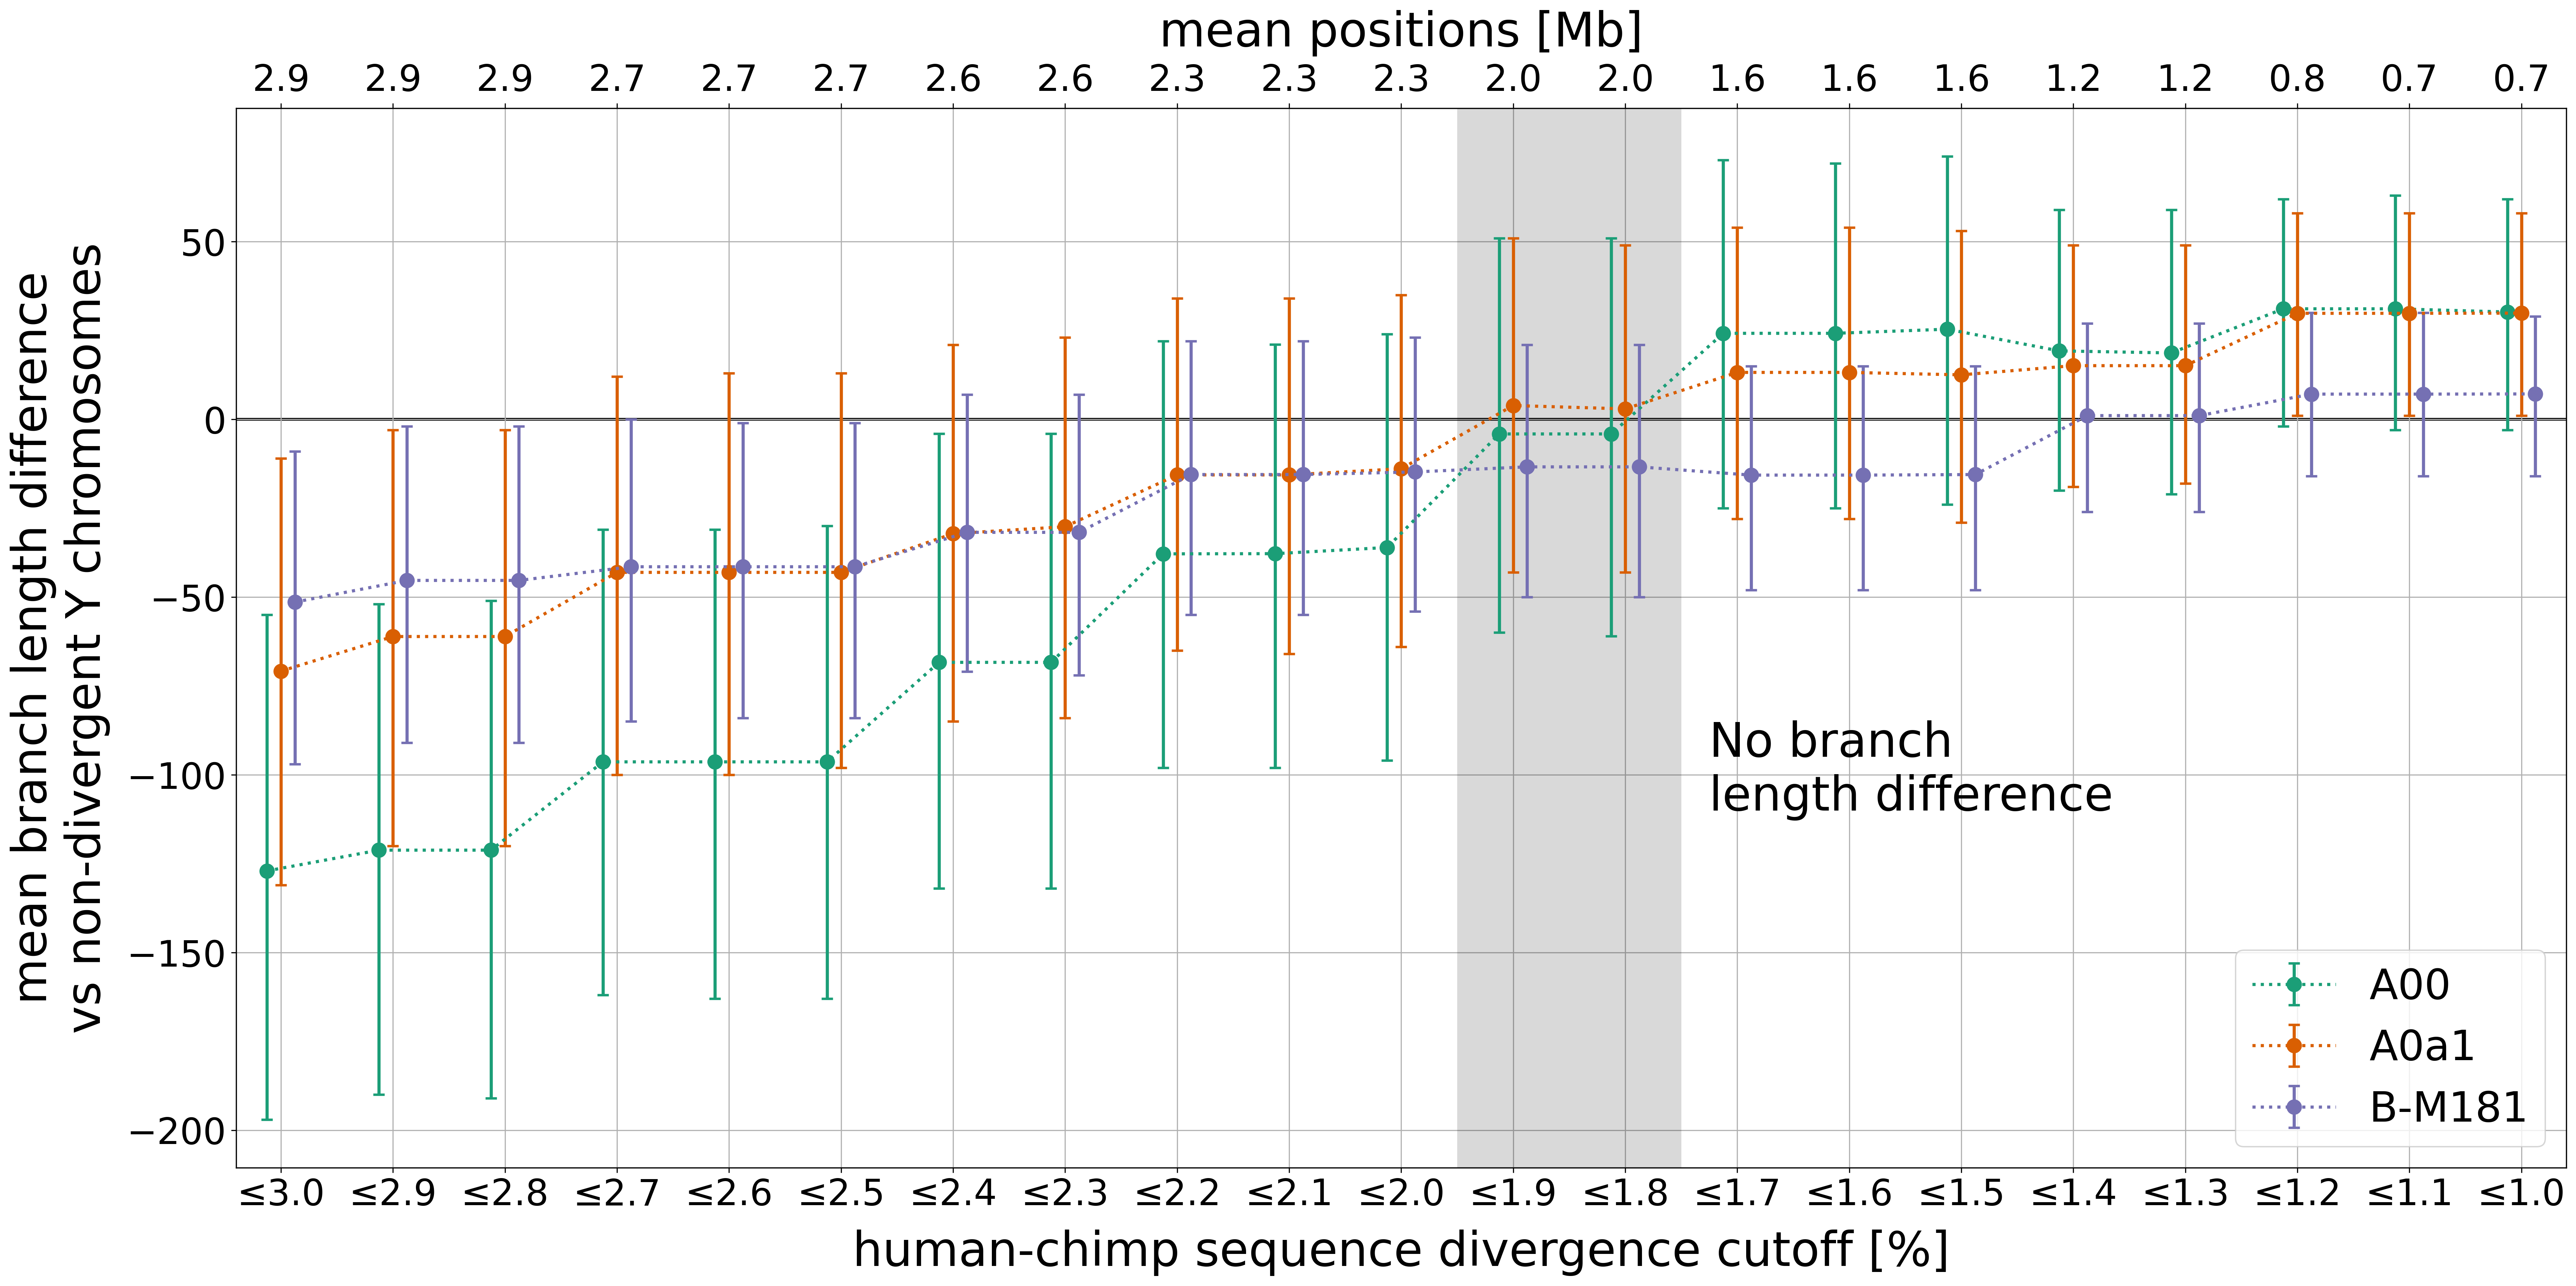

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import utils.YChrDataset as YChrDataset

import pickle
from matplotlib.transforms import Affine2D

mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update( {'mathtext.default': 'regular' } )
cmap = plt.cm.get_cmap('Dark2').colors

res = pickle.load(open('data/output_data/human_chimp_identity_cutoff_res.400_200.pkl', "rb"))

start = 97
end = 99
identity_cutoff = np.round(np.arange(start, end + 0.1, 0.1, dtype=float), 2)
identity_cutoff_str = [str(x) for x in identity_cutoff]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,14))

# Define transformations for plotting offset error bars
trans = [Affine2D().translate(-0.0125, 0.0) + ax.transData,
         Affine2D().translate(0, 0.0) + ax.transData,
         Affine2D().translate( +0.0125, 0.0) + ax.transData]

# Plot a placeholder for the legend entry
# ax.plot(np.NaN, np.NaN, '-', color='none', label='vs non-divergent Y chromosomes')

i = 0
for key, value in res.items():
    # if key in ['A00', 'HGDP01406', 'HGDP01029', 'HGDP00478', 'HGDP00984', 'mean_positions']:
    if key in ['A00', 'HG02982', 'HGDP00931', 'mean_positions']:
        if key != 'mean_positions':
            y = []
            y_low = []
            y_high = []
            x = []
            for col in identity_cutoff_str:
                y.append(value[col][0][0])
                y_low.append(value[col][0][0] - value[col][0][1])
                y_high.append(value[col][0][2] - value[col][0][0])
                x.append(float(col))
            if key not in ['mean_positions']:
                plot_label = YChrDataset.GetHaplogroup(key)
            else:
                plot_label = key

            plot_label = plot_label

            ax.errorbar(x, y, yerr=(y_low, y_high), fmt=':', capsize=4, capthick=1.75, label=plot_label, transform=trans[i], marker='o', markersize=10, lw=2.25, color=cmap[i])
            ax.set_xticks(x)
        else:
            labels = []
            labels_top = []
            for col in identity_cutoff_str:
                labels.append("≤{:.1f}".format(100 - float(col)))
                labels_top.append(str(np.round(value[col]/1000000, 1)))
            ax.set_xticklabels(labels, fontsize=16)

        i = i + 1

ax.grid()
ax.legend(loc='lower right', fontsize=30)
ax.set_xlim([96.96, 99.04])

plt.yticks(fontsize=26)
plt.xticks(fontsize=26)

ax.set_ylabel('mean branch length difference\nvs non-divergent Y chromosomes', fontsize=34, labelpad=12)
ax.set_xlabel('human-chimp sequence divergence cutoff [%]', fontsize=34, labelpad=12)
ax.text(98.275, -110, 'No branch\nlength difference', fontsize = 34)
ax.axvspan(98.05, 98.25, alpha=0.15, color='black', ec=None)

plt.axhline(0, lw=2, color='black', zorder=0)

ax.set_axisbelow(True)

# Create a twin x-axis for showing mean positions in Mb
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('mean positions [Mb]', fontsize=34, labelpad=12)
ax2.set_xticks(x)
ax2.set_xticklabels(labels_top, fontsize=26);


# Proportion of heterozygotes (indicative of mapping/genotyping errors) in the full hg19 Y chromosome and in the conserved regions of the Y chromosome

In [10]:
import pandas as pd
import utils.VcfHandler as VcfHandler
import utils.YChrDataset as YChrDataset

human_chimp_identity_cutoff = 0.981

human_chimp_identity_df = pd.read_csv('human_chimp_divergence/hg19_panTro6_chrY_identity_rolling_window.400_200.2500000_30000000.csv', sep='\t', header=None, names=['identity'])
human_chimp_identity_df['POS'] = human_chimp_identity_df.index + 1

# Load heterozygote data and drop rows with multiple ALT alleles
het_data = VcfHandler.get_heterozygotes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))
het_data = het_data[~het_data['ALT'].str.contains(",")]
het_data.reset_index(drop=True, inplace=True)

# Merge and filter based on identity
het_data_filtered_by_identity = pd.merge(het_data, human_chimp_identity_df, on=['POS'], how='inner')
het_data_filtered_by_identity = het_data_filtered_by_identity[het_data_filtered_by_identity['identity'] >= human_chimp_identity_cutoff]

hets = []
for ind in YChrDataset.samples:
    prop_unfiltered = het_data[ind].sum()/het_data[ind].notna().sum()
    prop_filtered = het_data_filtered_by_identity[ind].sum()/het_data_filtered_by_identity[ind].notna().sum()
    change = ( ( prop_filtered - prop_unfiltered ) / prop_unfiltered ) * 100
    hets.append([ind,
                 het_data[ind].sum(), round(prop_unfiltered, 8),
                 het_data_filtered_by_identity[ind].sum(), round(prop_filtered, 8),
                 round(change, 2)])

df = pd.DataFrame(hets, columns=['Individual', 'Heterozygotes (unfiltered)', 'Proportion (unfiltered)', 'Heterozygotes (filtered)', 'Proportion (filtered)', 'Change'])

with pd.option_context('display.precision', 9):
    display(df)

Individual  Heterozygotes (unfiltered)  Proportion (unfiltered)  \
0   Chagyrskaya2                          85               0.00002001   
1   Mezmaiskaya2                         140               0.00003336   
2     A00_I10871                         159               0.00003961   
3            A00                         387               0.00008867   
4        HG02982                          95               0.00002192   
5        HG02666                          67               0.00001558   
6      HGDP01029                         177               0.00004096   
7      HGDP01406                         178               0.00004141   
8      HGDP00931                          93               0.00002161   
9      HGDP00478                          90               0.00002082   
10     HGDP00453                          93               0.00002156   
11     HGDP00475                          92               0.00002120   
12     HGDP00984                          74               0.00001715   
13     HGDP00757                          57               0.00001320   
14     HGDP01214                          40               0.00000923   
15     HGDP01031                          78               0.00001806   
16     HGDP01200                          90               0.00002078   
17     HGDP00908                          99               0.00002307   
18     HGDP00103                          48               0.00001109   
19     HGDP00213                          82               0.00001908   
20     Loschbour                         118               0.00002737   
21     HGDP00127                          95               0.00002202   
22     HGDP00057                         110               0.00002558   
23     HGDP00056                          59               0.00001369   
24     Ust_Ishim                         106               0.00002458   
25     HGDP00549                          71               0.00001655   
26         Yana1                         188               0.00004376   
27     HGDP01009                          49               0.00001138   
28     HGDP00136                         111               0.00002575   
29     HGDP01075                          86               0.00001991   
30     HGDP00218                          58               0.00001343   
31     HGDP01298                          68               0.00001576   
32     HGDP01192                          59               0.00001374   
33     HGDP01225                          58               0.00001344   
34     HGDP01190                          90               0.00002085   

    Heterozygotes (filtered)  Proportion (filtered)  Change  
0                         14             0.00000685  -65.79  
1                         21             0.00001046  -68.66  
2                         56             0.00002921  -26.25  
3                         44             0.00002094  -76.39  
4                         15             0.00000719  -67.18  
5                          4             0.00000194  -87.58  
6                         66             0.00003175  -22.50  
7                         80             0.00003855   -6.92  
8                         10             0.00000481  -77.74  
9                          8             0.00000383  -81.61  
10                         8             0.00000384  -82.20  
11                         6             0.00000287  -86.48  
12                        15             0.00000719  -58.10  
13                         7             0.00000338  -74.41  
14                         5             0.00000239  -74.09  
15                        13             0.00000625  -65.41  
16                         9             0.00000429  -79.37  
17                         7             0.00000337  -85.40  
18                         8             0.00000384  -65.40  
19                         3             0.00000145  -92.42  
20                        30             0.00001452  -46.94  
21           

# Generate .bed file based on the optimal human-chimp divergence cutoff

In [7]:
import pandas as pd
from itertools import groupby
from operator import itemgetter

human_chimp_identity_cutoff = 0.981

# Filter the human-chimp identity dataframe based on the identity cutoff
human_chimp_identity_df = pd.read_csv('human_chimp_divergence/hg19_panTro6_chrY_identity_rolling_window.400_200.2500000_30000000.csv', sep='\t', header=None, names=['identity'])
filter_df = human_chimp_identity_df[human_chimp_identity_df['identity'] >= human_chimp_identity_cutoff].index

# Group consecutive indices to find start and end of conserved regions
bed_ranges = []
for k, g in groupby(enumerate(filter_df), lambda ix : ix[0] - ix[1]):
    temp = list(map(itemgetter(1), g))
    start = temp[0]
    end = temp[-1] + 1
    bed_ranges.append(['Y', start, end])

# Save the BED ranges to a file
res_df = pd.DataFrame(bed_ranges)
res_df[[0, 1, 2]].to_csv('hg19_panTro6_chrY_conserved.{0}.bed'.format(human_chimp_identity_cutoff), sep='\t', index=None, header=None)


# Get positions removed in each Y chromosome region

In [3]:
import utils.VcfHandler as VcfHandler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import itertools
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi'] = 400
pd.options.mode.chained_assignment = None

cmap = plt.cm.get_cmap('Set1').colors
colours = {
    'Pseudoautosomal' : cmap[0],
    'X-degenerate' : cmap[1],
    'X-transposed' : cmap[2],
    'Ampliconic' : cmap[3],
    'Others': cmap[4],
    'Heterochromatic' : cmap[5],
}

def get_filter_coordinates(filter):
    filter_ranges = [range(x1, x2) for x1, x2 in zip(filter[1], filter[2])]
    flat_list = list(itertools.chain.from_iterable(filter_ranges))
    filter_df = pd.DataFrame(index=range(0, 57217415 + 1), columns=[0], data=0)
    filter_df.loc[flat_list, 0] = 1
    return filter_df

human_chimp_identity_cutoff = 0.981

mappable_positions_df = get_filter_coordinates(VcfHandler.read_bed_file('data/input_data/hg19_mapped/masks/map35_100_capture_full.bed'))

human_chimp_identity_df = pd.read_csv('human_chimp_divergence/hg19_panTro6_chrY_identity_rolling_window.400_200.2500000_30000000.csv', sep='\t', header=None, names=['identity'])
human_chimp_identity_df = pd.merge(mappable_positions_df, human_chimp_identity_df, left_index=True, right_index=True, how='outer')
human_chimp_aligned_df = human_chimp_identity_df[(human_chimp_identity_df[0] == 1) & (human_chimp_identity_df['identity'].notna())]
removed_data_divergence_df = human_chimp_aligned_df[((human_chimp_aligned_df['identity'] < human_chimp_identity_cutoff) & (human_chimp_aligned_df[0] == 1)) |
                                                    ((human_chimp_aligned_df['identity'].isna()) & (human_chimp_aligned_df[0] == 1))]

removed_data_divergence = pd.DataFrame(index=range(0, 57217415 + 1), columns=[0], data=0)
removed_data_divergence.loc[removed_data_divergence_df.index, 0] = 1

human_chimp_aligned = pd.DataFrame(index=range(0, 57217415 + 1), columns=[0], data=0)
human_chimp_aligned.loc[human_chimp_aligned_df.index, 0] = 1

regions = [[0, 2649373, 'Pseudoautosomal'],
           [2649374, 2917723, 'X-degenerate'],
           [2917724, 6102644, 'X-transposed'],
           [6102645, 6400507, 'Ampliconic'],
           [6400508, 6616338, 'X-transposed'],
           [6616339, 7472224, 'X-degenerate'],
           [7472225, 9967983, 'Ampliconic'],
           [9967984, 10034804, 'Others'],
           [10034805, 13870015, 'Heterochromatic'],
           [13870016, 14071702, 'Others'],
           [14071703, 16095786, 'X-degenerate'],
           [16095787, 16170059, 'Ampliconic'],
           [16170060, 17986473, 'X-degenerate'],
           [17986474, 18016662, 'Ampliconic'],
           [18016663, 18271273, 'X-degenerate'],
           [18271274, 18537442, 'Ampliconic'],
           [18537443, 19567356, 'X-degenerate'],
           [19567357, 21031900, 'Ampliconic'],
           [21031901, 22216158, 'X-degenerate'],
           [22216159, 22512749, 'Heterochromatic'],
           [22512750, 23497632, 'X-degenerate'],
           [23497633, 28809633, 'Ampliconic'],
           [28809634, 29224634, 'Others'],
           [29224635, 56887902, 'Heterochromatic'],
           [56887903, 57217415, 'Pseudoautosomal']]

total_positions = {
    'Total' : 0,
    'Pseudoautosomal' : 0,
    'X-degenerate' : 0,
    'X-transposed' : 0,
    'Ampliconic' : 0,
    'Others': 0,
    'Heterochromatic' : 0,
}

mappable_positions = {
    'Total' : [],
    'Pseudoautosomal' : [],
    'X-degenerate' : [],
    'X-transposed' : [],
    'Ampliconic' : [],
    'Others': [],
    'Heterochromatic' : [],
}

removed_positions = {
    'Total' : [],
    'Pseudoautosomal' : [],
    'X-degenerate' : [],
    'X-transposed' : [],
    'Ampliconic' : [],
    'Others': [],
    'Heterochromatic' : [],
}

human_chimp_aligned_positions = {
    'Total' : [],
    'Pseudoautosomal' : [],
    'X-degenerate' : [],
    'X-transposed' : [],
    'Ampliconic' : [],
    'Others': [],
    'Heterochromatic' : [],
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(76, 3))

# Plot mappable positions
ax.plot(mappable_positions_df.index, mappable_positions_df[0] * 0.5, 'k', lw=0.015)

alpha=0.6
max_bp = 30.5e6
for region in regions:
    region_range = range(region[0], region[1])
    region_name = region[2]

    region_sum = region[1] + 1 - region[0]
    total_positions[region_name] = total_positions[region_name] + region_sum
    total_positions['Total'] = total_positions['Total'] + region_sum

    mappable_positions_in_region = mappable_positions_df.loc[region_range].sum()[0]
    removed_positions_in_region = removed_data_divergence.loc[region_range].sum()[0]
    human_chimp_aligned_positions_in_region = human_chimp_aligned.loc[region_range].sum()[0]

    mappable_positions[region_name].append(mappable_positions_in_region)
    removed_positions[region_name].append(removed_positions_in_region)
    human_chimp_aligned_positions[region_name].append(human_chimp_aligned_positions_in_region)

    mappable_positions['Total'].append(mappable_positions_in_region)
    removed_positions['Total'].append(removed_positions_in_region)
    human_chimp_aligned_positions['Total'].append(human_chimp_aligned_positions_in_region)

    # if region_name == 'X-degenerate':
    #     y = -1.9
    #     x = region[0] + ( (region[1] - region[0]) / 2) + 5e4
    #     ha = 'right'
    # else:
    #     y = 1.05
    #     x = region[0] + ( (region[1] - region[0]) / 2) - 1e5
    #     ha = 'left'

    # if mappable_positions_in_region > 0:
    #     prop_removed = round((removed_positions_in_region / mappable_positions_in_region) * 100)
    #     if (x < max_bp):
    #         ax.text(x, y, str(round(mappable_positions_in_region)) + ' [' + str(prop_removed) + '%]', rotation=40, ha=ha, fontsize=40)
    # else:
    #     if (x < max_bp):
    #         ax.text(x, y, str(round(mappable_positions_in_region)), rotation=40, ha=ha, fontsize=40)

for region in regions:
    region_name = region[2]
    if region[1] < max_bp:
        ax.axvspan(region[0], region[1], alpha=0.6, color=colours[region_name], ec=None)
    else:
        ax.axvspan(region[0], max_bp, alpha=0.6, color=colours[region_name], ec=None)
        break

# Get total mappable/removed for each region
label_list = []
for region in mappable_positions.keys():
    total_mappable_positions = sum(mappable_positions[region])
    total_removed_positions = sum(removed_positions[region])
    total_aligned_positions = sum(human_chimp_aligned_positions[region])

    if total_mappable_positions > 0:
        label_list.append(f"{region}: {total_mappable_positions:,} [{round(total_mappable_positions / total_positions[region] * 100, 2)}%]")

        if total_aligned_positions > 0:
            print(region +
                ' Mappable positions: ' + str(total_mappable_positions) +
                ' Aligned positions: ' + str(total_aligned_positions) +
                ' [' + str(round((total_aligned_positions / total_mappable_positions) * 100)) +  '%]' +
                ' Retained positions: ' + str(total_aligned_positions - total_removed_positions) +
                ' [' + str(100 - round((total_removed_positions / total_aligned_positions) * 100)) +  '%]')
        else:
            print(region +
                ' Mappable positions: ' + str(total_mappable_positions) +
                ' Aligned positions: ' + str(total_aligned_positions) +
                ' [NA]' +
                ' Retained positions: ' + str(total_aligned_positions - total_removed_positions) +
                ' [NA]')
    else:
        label_list.append(f"{region}: {total_mappable_positions} [NA]")

        print(region + ' Mappable positions: ' + str(total_mappable_positions) + ' [NA]')

print('Others, Heterochromatic' +
      ' Mappable positions: ' + str(sum(mappable_positions['Others']) + sum(mappable_positions['Heterochromatic'])) +
      ' Aligned positions: ' + str(sum(human_chimp_aligned_positions['Others']) + sum(human_chimp_aligned_positions['Heterochromatic'])) +
      ' [' + str(round( (sum(human_chimp_aligned_positions['Others']) + sum(human_chimp_aligned_positions['Heterochromatic'])) / (sum(mappable_positions['Others']) + sum(mappable_positions['Heterochromatic'])) * 100) ) +  '%]' +
      ' Retained positions: ' + str(sum(human_chimp_aligned_positions['Others']) + sum(human_chimp_aligned_positions['Heterochromatic']) - sum(removed_positions['Others']) - sum(removed_positions['Heterochromatic'])) +
      ' [' + str(100 - round( ( (sum(removed_positions['Others']) + sum(removed_positions['Heterochromatic']) ) / (sum(human_chimp_aligned_positions['Others']) + sum(human_chimp_aligned_positions['Heterochromatic'])) ) * 100) ) +  '%]')

handles, labels = ax.get_legend_handles_labels()
fig.legend(fontsize=70, ncol=2,
    handles = [
        Line2D([], [], c=cmap[0], label=list(colours.keys())[0], marker='o', linestyle='None', markersize=50, alpha=0),
        Line2D([], [], c=cmap[0], label=list(colours.keys())[0], marker='o', linestyle='None', markersize=50, alpha=0.8),
        Line2D([], [], c=cmap[1], label=list(colours.keys())[1], marker='o', linestyle='None', markersize=50, alpha=0.8),
        Line2D([], [], c=cmap[2], label=list(colours.keys())[2], marker='o', linestyle='None', markersize=50, alpha=0.8),
        Line2D([], [], c=cmap[3], label=list(colours.keys())[3], marker='o', linestyle='None', markersize=50, alpha=0.8),
        Line2D([], [], c=cmap[4], label=list(colours.keys())[4], marker='o', linestyle='None', markersize=50, alpha=0.8),
        Line2D([], [], c=cmap[5], label=list(colours.keys())[5], marker='o', linestyle='None', markersize=50, alpha=0.8)
    # ], labels = label_list, loc='center right', bbox_to_anchor=(1.18, 0.5), frameon=False)
    ], labels = label_list, loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)

ax.text(0, 1.05, '0 Mb', fontsize=60)
ax.text(10e6, 1.05, '10 Mb', fontsize=60)
ax.text(20e6, 1.05, '20 Mb', fontsize=60)
ax.text(30e6, 1.05, '30 Mb', fontsize=60)

ax.set_xlim([-10000, max_bp + 500000])
ax.set_ylim([0, 1])

ax.plot([0, max_bp + 500000], [0, 0], 'k', lw=5)
ax.plot([0, max_bp + 500000], [1, 1], 'k', lw=5)

plt.vlines(x=[x[0] for x in regions], colors='k', ymin=0, ymax=1, lw=5)

ax.set_yticks([])
temp = ax.set_xticks([-1e6])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

Total Mappable positions: 4602349 Aligned positions: 3850106 [84%] Retained positions: 2200818 [57%]
Pseudoautosomal Mappable positions: 0 [NA]
X-degenerate Mappable positions: 3701385 Aligned positions: 3476366 [94%] Retained positions: 2151164 [62%]
X-transposed Mappable positions: 27214 Aligned positions: 0 [NA] Retained positions: 0 [NA]
Ampliconic Mappable positions: 834298 Aligned positions: 336588 [40%] Retained positions: 38196 [11%]
Others Mappable positions: 27867 Aligned positions: 27251 [98%] Retained positions: 10436 [38%]
Heterochromatic Mappable positions: 11585 Aligned positions: 9901 [85%] Retained positions: 1022 [10%]
Others, Heterochromatic Mappable positions: 39452 Aligned positions: 37152 [94%] Retained positions: 11458 [31%]


# Generate fasta files for BEAST analysis

## Full dataset - Unfiltered

In [7]:
import pandas as pd
import utils.VcfHandler as VcfHandler
import sys
sys.path.append('../')

genotype_data = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))
genotype_data = VcfHandler.filter_vcf(genotype_data, 'data/input_data/hg19_mapped/masks/map35_100_capture_full.bed')

VcfHandler.prep_fasta_for_beast(genotype_data, 'BEAST/data_full.fa')


(A    32447
 T    32388
 G    31646
 C    31512
 Name: REF, dtype: int64,
 T    1383443
 A    1380805
 G     856861
 C     852256
 Name: REF, dtype: int64)

## Full dataset - Filtered

In [8]:
import pandas as pd
import utils.VcfHandler as VcfHandler

human_chimp_identity_cutoff = 0.981

genotype_data = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))
genotype_data = VcfHandler.filter_vcf(genotype_data, 'data/input_data/hg19_mapped/masks/map35_100_capture_full.bed')

VcfHandler.prep_fasta_for_beast(genotype_data, 'BEAST/data_full_divergence_filtered.fa', 'human_chimp_divergence/hg19_panTro6_chrY_identity_rolling_window.400_200.2500000_30000000.csv', human_chimp_identity_cutoff)


(G    8121
 C    8064
 A    7682
 T    7607
 Name: REF, dtype: int64,
 T    679387
 A    678097
 G    407713
 C    404021
 Name: REF, dtype: int64)

## Removed A00 - Unfiltered

In [9]:
import pandas as pd
import utils.VcfHandler as VcfHandler

genotype_data = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))
genotype_data = genotype_data.drop(['A00'], axis=1)
genotype_data = VcfHandler.filter_vcf(genotype_data, 'data/input_data/hg19_mapped/masks/map35_100_capture_full.bed')

VcfHandler.prep_fasta_for_beast(genotype_data, 'BEAST/data_full_no_A00.fa')


(A    32402
 T    32344
 G    31597
 C    31460
 Name: REF, dtype: int64,
 T    1383487
 A    1380850
 G     856908
 C     852307
 Name: REF, dtype: int64)

## Removed A00 - filtered

In [10]:
import pandas as pd
import utils.VcfHandler as VcfHandler

human_chimp_identity_cutoff = 0.981

genotype_data = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))
genotype_data = genotype_data.drop(['A00'], axis=1)
genotype_data = VcfHandler.filter_vcf(genotype_data, 'data/input_data/hg19_mapped/masks/map35_100_capture_full.bed')

VcfHandler.prep_fasta_for_beast(genotype_data, 'BEAST/data_full_no_A00_divergence_filtered.fa', 'human_chimp_divergence/hg19_panTro6_chrY_identity_rolling_window.400_200.2500000_30000000.csv', human_chimp_identity_cutoff)

(G    8101
 C    8041
 A    7667
 T    7590
 Name: REF, dtype: int64,
 T    679404
 A    678112
 G    407732
 C    404043
 Name: REF, dtype: int64)

# Get relative mutation count differences (compared to R1b1a2a1a2b and A00) after filtering

In [11]:
import pandas as pd
import numpy as np
import pickle

import utils.VcfHandler as VcfHandler
import utils.BranchShortening as BranchShortening
import utils.YChrDataset as YChrDataset

rng = np.random.default_rng()

samples = YChrDataset.samples
vcf_data = VcfHandler.get_genotypes_from_vcf_dataframe(pd.read_pickle('data/input_data/data_full_merged.hg19_mapped.vcf.gz.pkl'))

human_chimp_identity_cutoff = 0.981

human_chimp_divergence_df = pd.read_csv('human_chimp_divergence/hg19_panTro6_chrY_identity_rolling_window.400_200.2500000_30000000.csv', sep='\t', header=None, names=['identity'])
human_chimp_divergence_df['POS'] = human_chimp_divergence_df.index + 1

vcf_data_filtered_by_divergence = pd.merge(vcf_data, human_chimp_divergence_df, on=['POS'], how='inner')
vcf_data_filtered_by_divergence = vcf_data_filtered_by_divergence[vcf_data_filtered_by_divergence['identity'] >= human_chimp_identity_cutoff]

res = BranchShortening.get_mutations_vs_individual(vcf_data_filtered_by_divergence, 'HGDP01075', samples)
pickle.dump(res, open('data/output_data/mutation_diff_filtered_by_divergence_HGDP01075.pkl', "wb"))

res = BranchShortening.get_mutations_vs_individual(vcf_data_filtered_by_divergence, 'A00', samples)
pickle.dump(res, open('data/output_data/mutation_diff_filtered_by_divergence_A00.pkl', "wb"))

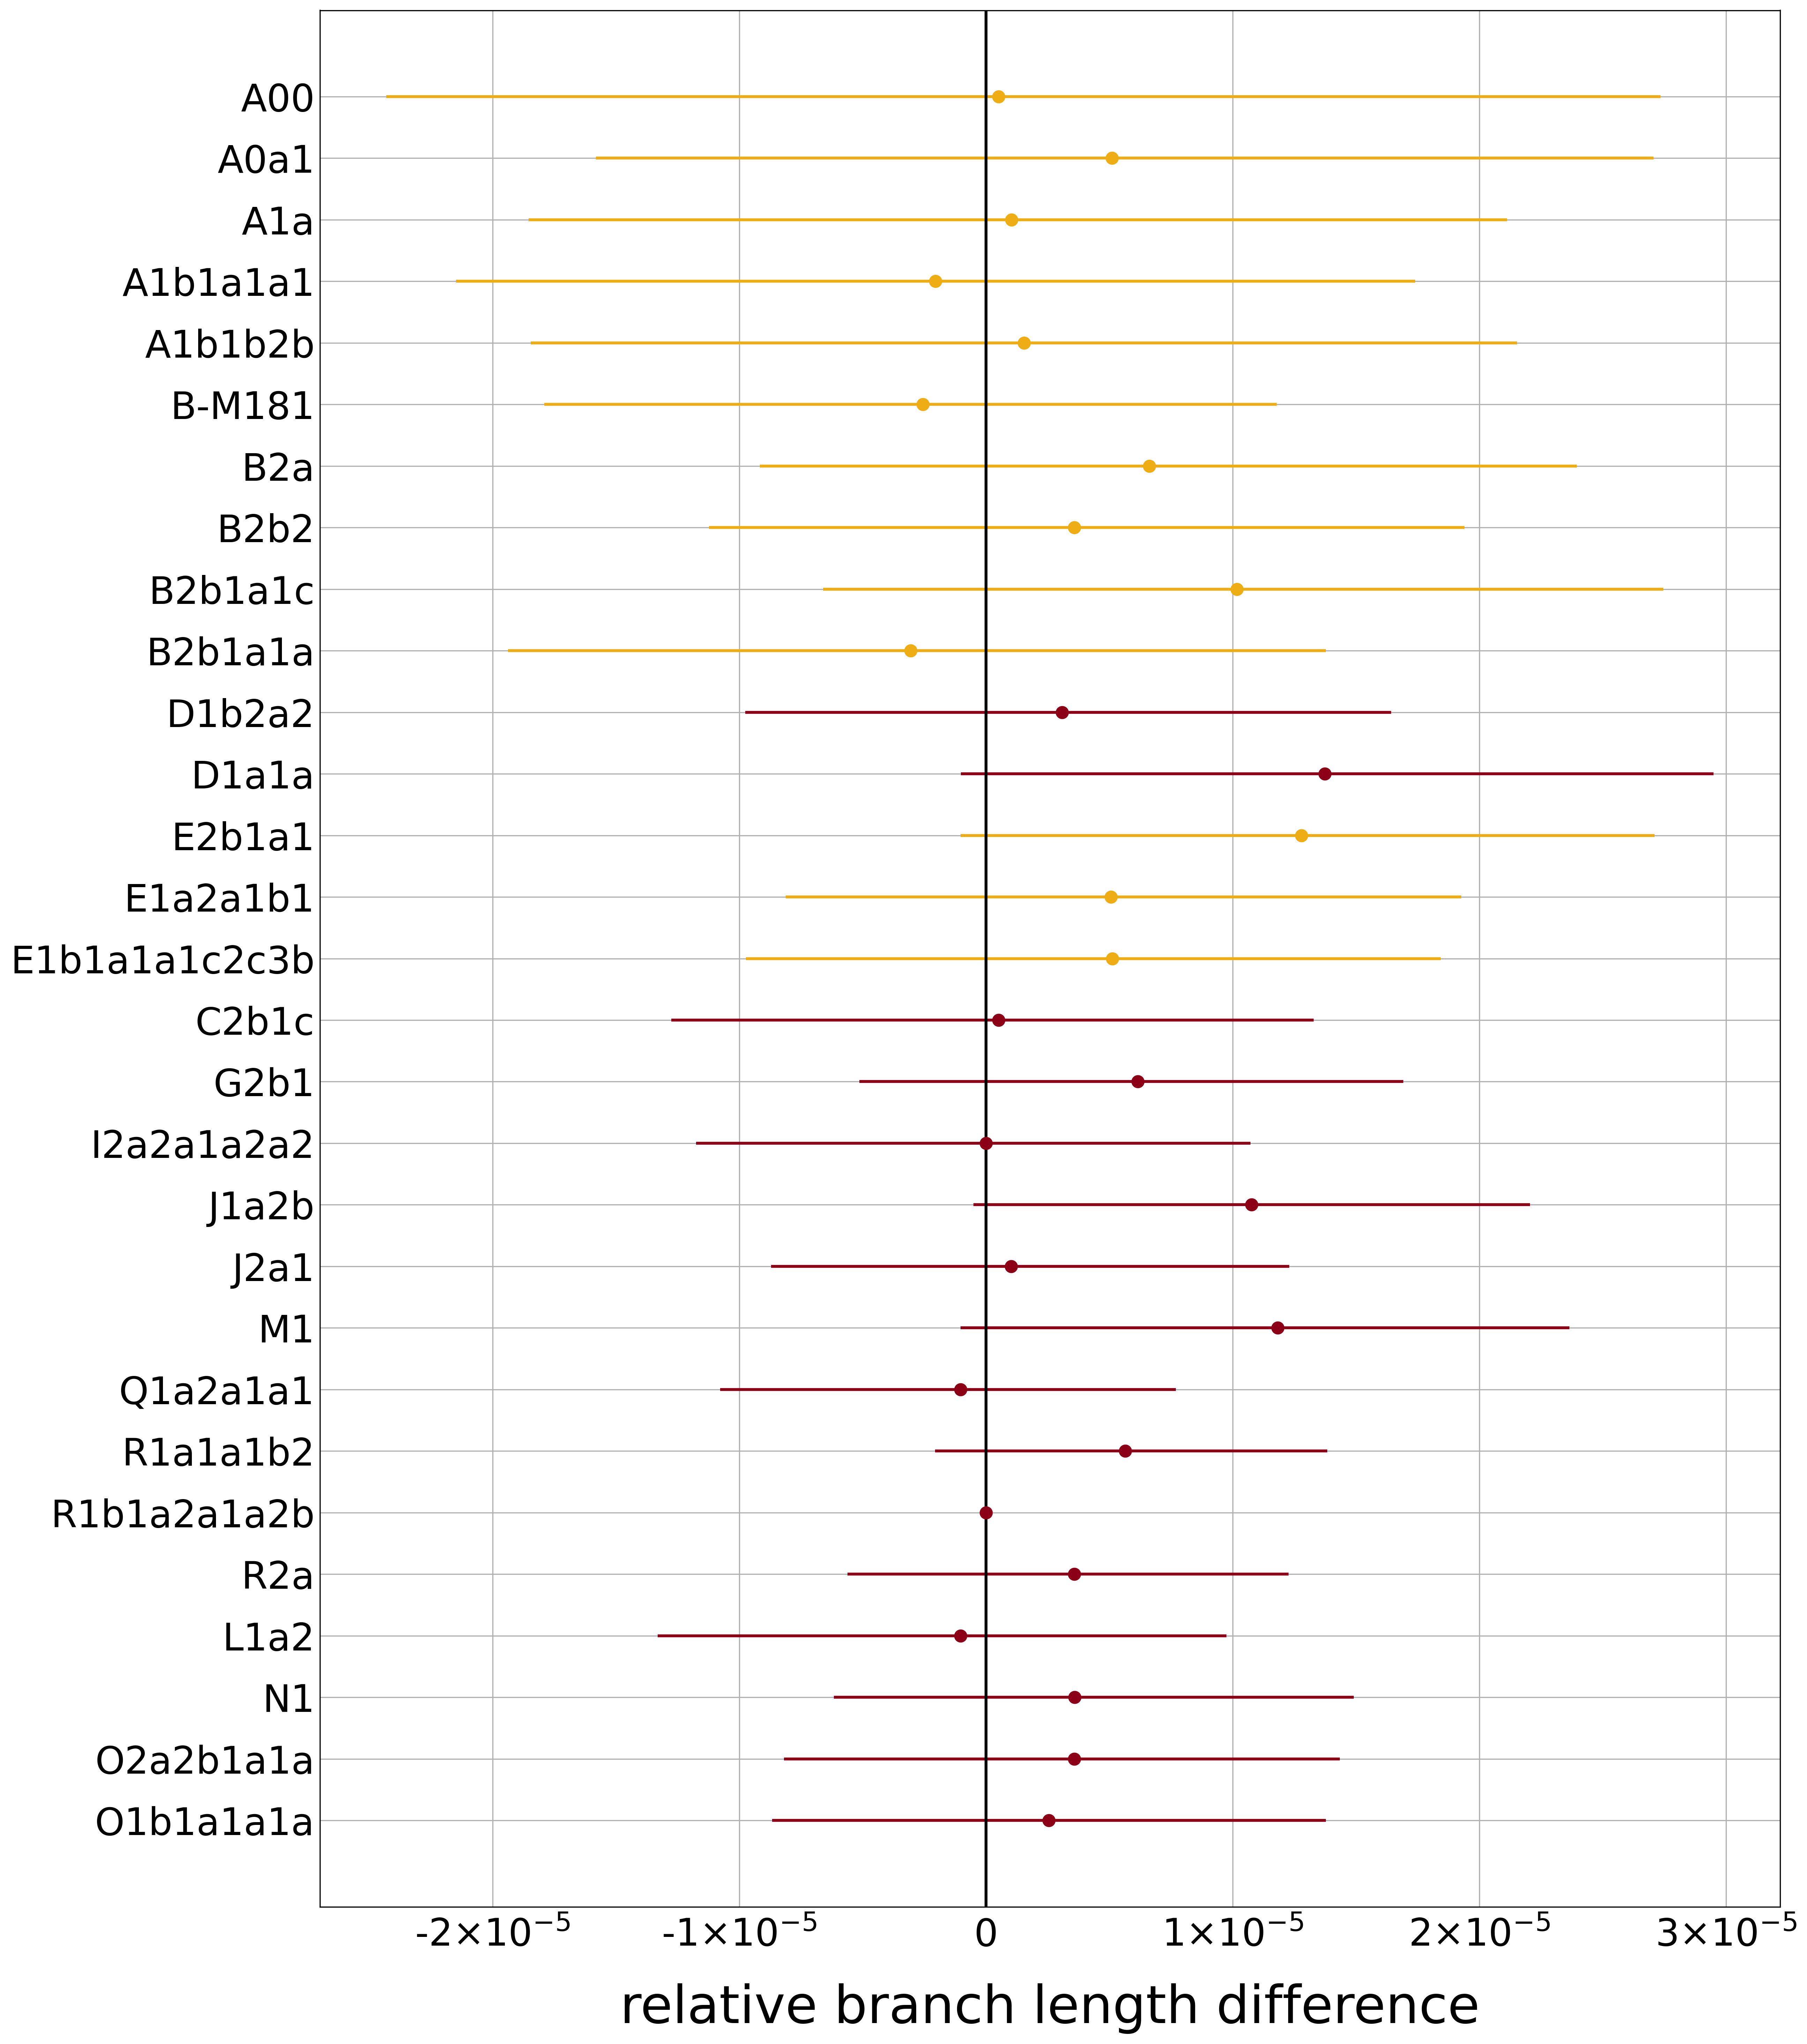

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle

import utils.YChrDataset as YChrDataset

from matplotlib.ticker import FuncFormatter

def formatter(x, lim):
    if np.round(x, 6) == 0:
        return 0
    else:
        x = str("%fe-5" % (1e5 * x,)).split("e")
        return (str(int(float(x[0]))) + r"$\times 10^{" + str(np.round(int(float(x[1])))) + r"}$")

mpl.rcParams['figure.dpi'] = 300

rng = np.random.default_rng()

# Load and filter data
res = pickle.load(open('data/output_data/mutation_diff_filtered_by_divergence_HGDP01075.pkl', 'rb'))
res = {key: value for key, value in res.items() if key not in YChrDataset.ancient_samples}

# Prepare data for plotting
samples = [sample for sample in YChrDataset.samples if sample not in YChrDataset.ancient_samples] 
haplogroups = [YChrDataset.GetHaplogroup(x).split('\n', 1)[0] for x in samples]
pops = [YChrDataset.GetPop(x) for x in samples]

pop_colors = {'African': '#EFAD15', 'non-African': '#8B0017', 'default': '#1E74CB'}
colours = [pop_colors.get(pop, pop_colors['default']) for pop in pops]

x = [i['normalised_diff'][0] for i in res.values()]
x_low = [x - i['normalised_diff'][1][0] for i, x in zip(res.values(), x)]
x_high = [i['normalised_diff'][1][1] - x for i, x in zip(res.values(), x)]

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (18,24))
y_ticks = list(range(0, len(samples) * 4, 4))
for i, y in enumerate(y_ticks):
    ax.errorbar(x[i], y, xerr=np.array([[x_low[i]], [x_high[i]]]), ls='None', marker='o', color=colours[i],  markersize=8, lw=2)
    
plt.axvline(0, lw=2, color='black')
plt.grid()
plt.gca().invert_yaxis()

ax.set_yticks(y_ticks, haplogroups, ha='right', fontsize=26)
ax.xaxis.set_tick_params(labelsize=26, pad=7)

ax.set_xlabel('relative branch length difference', fontsize=36, labelpad=20)

ax.xaxis.set_major_formatter(FuncFormatter(formatter))
ax.tick_params(axis='both', which='both', length=0)


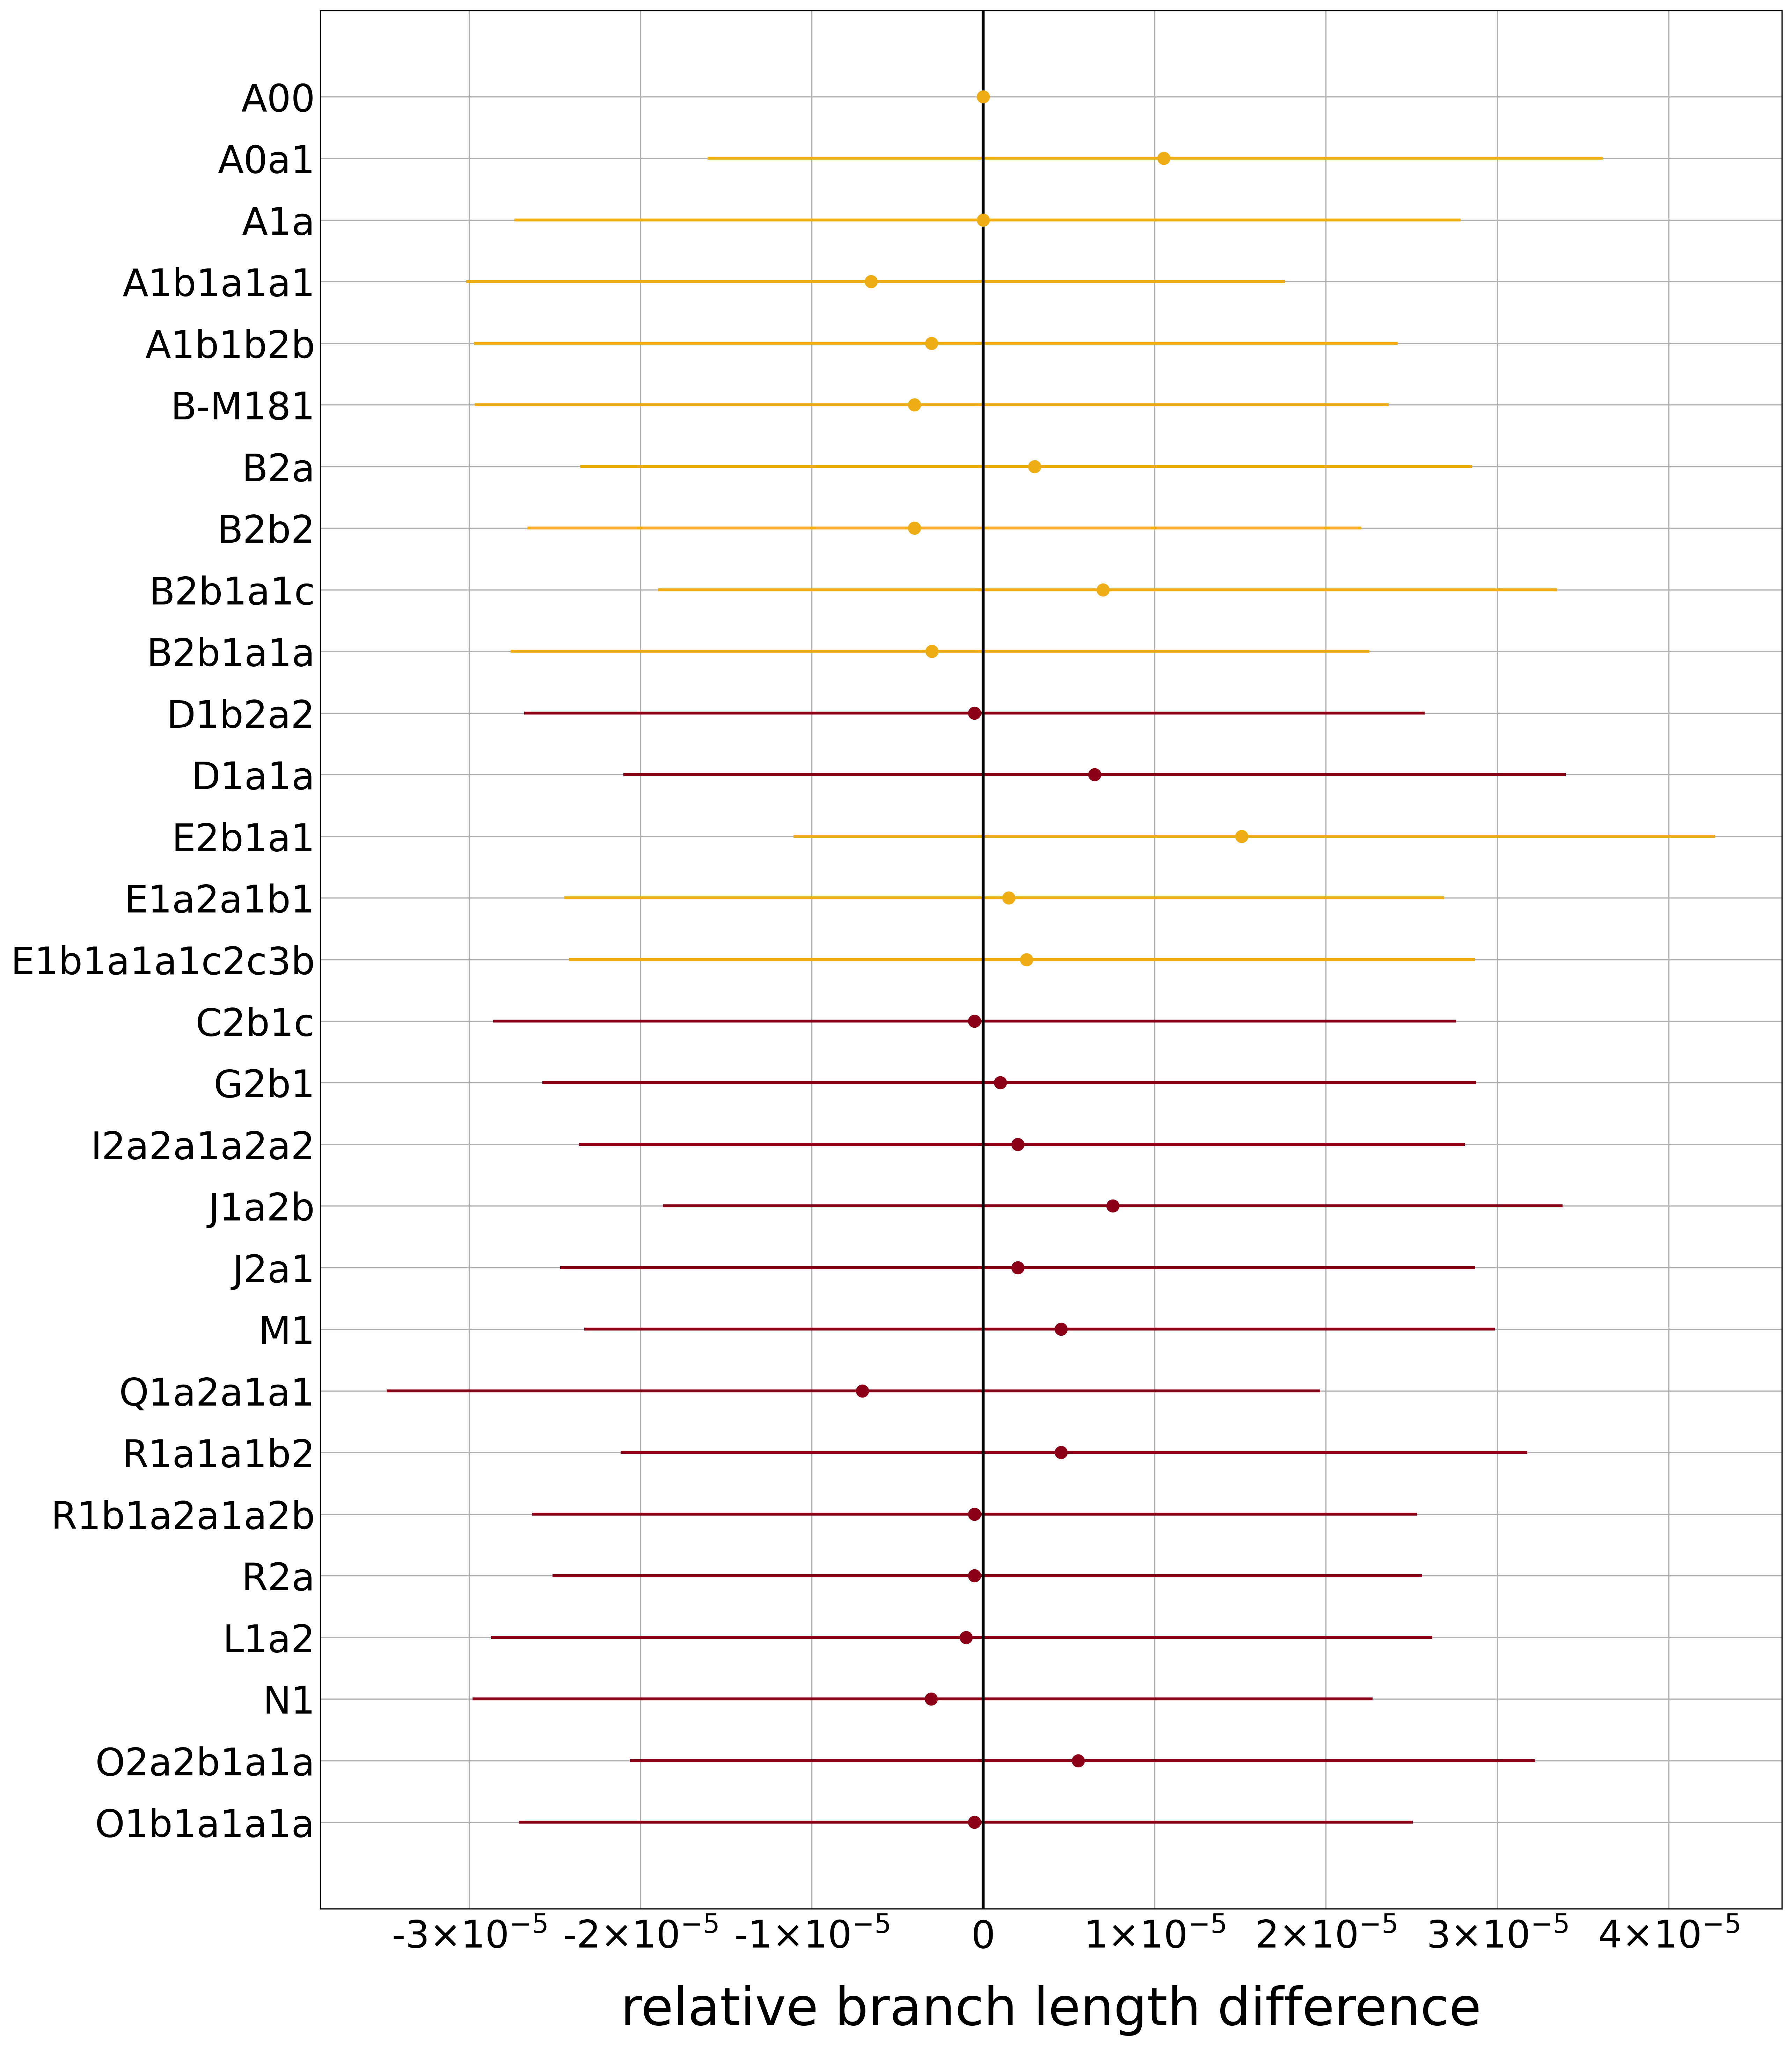

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle

import utils.YChrDataset as YChrDataset

from matplotlib.ticker import FuncFormatter

def formatter(x, lim):
    if np.round(x, 6) == 0:
        return 0
    else:
        x = str("%fe-5" % (1e5 * x,)).split("e")
        return (str(int(float(x[0]))) + r"$\times 10^{" + str(np.round(int(float(x[1])))) + r"}$")

mpl.rcParams['figure.dpi'] = 300

rng = np.random.default_rng()

# Load and filter data
res = pickle.load(open('data/output_data/mutation_diff_filtered_by_divergence_A00.pkl', 'rb'))
res = {key: value for key, value in res.items() if key not in YChrDataset.ancient_samples}

# Prepare data for plotting
samples = [sample for sample in YChrDataset.samples if sample not in YChrDataset.ancient_samples]
haplogroups = [YChrDataset.GetHaplogroup(x).split('\n', 1)[0] for x in samples]
pops = [YChrDataset.GetPop(x) for x in samples]

pop_colors = {'African': '#EFAD15', 'non-African': '#8B0017', 'default': '#1E74CB'}
colours = [pop_colors.get(pop, pop_colors['default']) for pop in pops]

x = [i['normalised_diff'][0] for i in res.values()]
x_low = [x - i['normalised_diff'][1][0] for i, x in zip(res.values(), x)]
x_high = [i['normalised_diff'][1][1] - x for i, x in zip(res.values(), x)]

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (18,24))
y_ticks = list(range(0, len(samples) * 4, 4))
for i, y in enumerate(y_ticks):
    ax.errorbar(x[i], y, xerr=np.array([[x_low[i]], [x_high[i]]]), ls='None', marker='o', color=colours[i],  markersize=8, lw=2)
    
plt.axvline(0, lw=2, color='black')
plt.grid()
plt.gca().invert_yaxis()

ax.set_yticks(y_ticks, haplogroups, ha='right', fontsize=26)
ax.xaxis.set_tick_params(labelsize=26, pad=7)

ax.set_xlabel('relative branch length difference', fontsize=36, labelpad=20)

ax.xaxis.set_major_formatter(FuncFormatter(formatter))
ax.tick_params(axis='both', which='both', length=0)
